# Load data

In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
import preprocessing
import os
import xrft
import gcm_filters
import random

warnings.filterwarnings("ignore")

importlib.reload(preprocessing)
from preprocessing import preprocess_data

from gcm_filtering import filter_inputs_dataset
from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
ds_merged = preprocess_data()
ds_merged

Load Data
Interpolating ocean velocities
Modify units
Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


<xarray.Dataset> Size: 3TB
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
    area_t        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

# Training dataset creation

### Input data: filtered SGS heat flux

In [3]:
Qstar = xr.open_dataset(
    "gs://leap-persistent/panalluri/HF_star.zarr", engine="zarr", chunks={}
)
Qstar

<xarray.Dataset> Size: 14GB
Dimensions:   (time: 365, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time      (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    data      (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>

### Choose same regions as Abigail

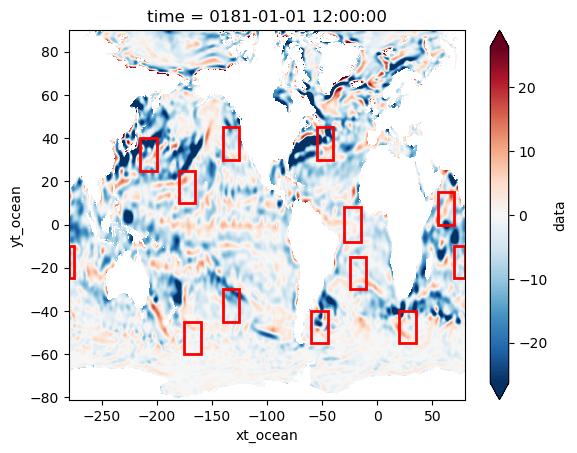

In [4]:
import matplotlib.pyplot as plt

# Example plot with Qstar.data
Qstar.data.isel(time=0).plot(robust=True)

# Define multiple latitude and longitude ranges
# (conversion to ds coords by hand for now)
boxes = [
    (30, 45, -40, -55),  # gulf stream = (30, 45, -60, -45)
    (-30, -15, -25, -10),  # south atlantic = (-30, -15, -25, -10)
    (-8, 8, -30, -15), # equator atlantic = (-8, 8, -30, -15)    
    (-55, -40, -60, -45), # malvinas current = (-55, -40, -60, -45)
    (30, 45, -140, -125), # california current = (30, 45, -140, -125)
    (-45, -30, -140, -125), # south pacific = (-45, -30, -140, -125)
    (25, 40, -215, -200), # kuroshio extension = (25, 40, 145, 160)
    (10, 25, -180, -165), # north pacific = (10, 25, -180, -165)
    (-60, -45, -175, -160), # southern ocean, new zealand = (-60, -45, -175, -160)
    (-55, -40, 20, 35), # agulhas current = (-55, -40, 20, 35)
    (-25, -10, 70, 79.95), # indian ocean (west chunk) = (-25, -10, 70, 85)
    (-25, -10, -279.95, -275), # indian ocean (east chunk) = (-25, -10, 70, 85)
    (0, 15, 55, 70) # arabian sea = (0, 15, 55, 70)
]

for lat_min, lat_max, lon_min, lon_max in boxes:

    # Draw the box on the plot
    plt.gca().add_patch(
        plt.Rectangle(
            (lon_min, lat_min),  # (x, y) start point
            lon_max - lon_min,  # width
            lat_max - lat_min,  # height
            fill=False,          # don't fill the box
            edgecolor='red',     # color of the box
            linewidth=2
        )
    )

# Show the plot
plt.show()


### Construct Q_star input and output data set for each region

In [5]:
print("Filtering model")
Qstar_out = filter_inputs_dataset(Qstar, ['yt_ocean', 'xt_ocean'], filter_scale=50, filter_type='gaussian')

Filtering model


In [6]:
# obtain monthly averaged data for the first year
Qstar_time = Qstar_out.isel(time=slice(0,365)).resample(time='M').mean()
Qstar_target_time = Qstar.isel(time=slice(0,365)).resample(time='M').mean()
Qstar_time.time

<xarray.DataArray 'time' (time: 12)> Size: 96B
array([cftime.DatetimeJulian(181, 1, 31, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(181, 2, 28, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(181, 3, 31, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(181, 4, 30, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(181, 5, 31, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(181, 6, 30, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(181, 7, 31, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(181, 8, 31, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(181, 9, 30, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(181, 10, 31, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(181, 11, 30, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(181, 12, 31, 0, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 96B 0181-01-31 00:00:00 ... 0181-12-31 00:00:00

In [7]:
# data samples of regions in the ocean
## ignore Qstar_gulfStream, not enough data for halo
ds_Qstar_dict = {
    # 'Qstar_gulfStream': Qstar_time.sel(yt_ocean=slice(30, 45), xt_ocean=slice(-40, -55)), 
    'Qstar_southAtlantic': Qstar_time.sel(yt_ocean=slice(-30, -15), xt_ocean=slice(-25, -10)),
    'Qstar_equatorAtlantic': Qstar_time.sel(yt_ocean=slice(-8, 8), xt_ocean=slice(-30, -15)),
    'Qstar_malvinasCurrent': Qstar_time.sel(yt_ocean=slice(-55, -40), xt_ocean=slice(-60, -45)),
    'Qstar_californiaCurrent': Qstar_time.sel(yt_ocean=slice(30, 45), xt_ocean=slice(-140, -125)),
    'Qstar_southPacific': Qstar_time.sel(yt_ocean=slice(-45, -30), xt_ocean=slice(-140, -125)),
    'Qstar_kuroshioExtension': Qstar_time.sel(yt_ocean=slice(25, 40), xt_ocean=slice(-215, -200)),
    'Qstar_northPacific': Qstar_time.sel(yt_ocean=slice(10, 25), xt_ocean=slice(-180, -165)),
    'Qstar_southernOcean': Qstar_time.sel(yt_ocean=slice(-60, -45), xt_ocean=slice(-175, -160)),
    'Qstar_agulhasCurrent': Qstar_time.sel(yt_ocean=slice(-55, -40), xt_ocean=slice(20, 35)),
    'Qstar_indianOceanWest': Qstar_time.sel(yt_ocean=slice(-25, -10), xt_ocean=slice(70, 79.95)),
    'Qstar_indianOceanEast': Qstar_time.sel(yt_ocean=slice(-25, -10), xt_ocean=slice(-279.95, -275)),
    'Qstar_arabianSea': Qstar_time.sel(yt_ocean=slice(0, 15), xt_ocean=slice(55, 70))
}
ds_Qstar_dict

{'Qstar_southAtlantic': <xarray.Dataset> Size: 1MB
 Dimensions:   (time: 12, yt_ocean: 163, xt_ocean: 150)
 Coordinates:
   * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
   * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
   * time      (time) object 96B 0181-01-31 00:00:00 ... 0181-12-31 00:00:00
 Data variables:
     data      (time, yt_ocean, xt_ocean) float32 1MB dask.array<chunksize=(1, 163, 150), meta=np.ndarray>
 Attributes:
     filter_scale:  50
     filter_type:   gaussian,
 'Qstar_equatorAtlantic': <xarray.Dataset> Size: 1MB
 Dimensions:   (time: 12, yt_ocean: 160, xt_ocean: 150)
 Coordinates:
   * xt_ocean  (xt_ocean) float64 1kB -29.95 -29.85 -29.75 ... -15.15 -15.05
   * yt_ocean  (yt_ocean) float64 1kB -7.925 -7.826 -7.726 ... 7.726 7.826 7.925
   * time      (time) object 96B 0181-01-31 00:00:00 ... 0181-12-31 00:00:00
 Data variables:
     data      (time, yt_ocean, xt_ocean) float32 1MB dask.array<chunksize=(1, 160,

In [8]:
# data samples of regions in the ocean
ds_Qstar_target_dict = {
    'Qstar_southAtlantic': Qstar_target_time.sel(yt_ocean=slice(-30, -15), xt_ocean=slice(-25, -10)),
    'Qstar_equatorAtlantic': Qstar_target_time.sel(yt_ocean=slice(-8, 8), xt_ocean=slice(-30, -15)),
    'Qstar_malvinasCurrent': Qstar_target_time.sel(yt_ocean=slice(-55, -40), xt_ocean=slice(-60, -45)),
    'Qstar_californiaCurrent': Qstar_target_time.sel(yt_ocean=slice(30, 45), xt_ocean=slice(-140, -125)),
    'Qstar_southPacific': Qstar_target_time.sel(yt_ocean=slice(-45, -30), xt_ocean=slice(-140, -125)),
    'Qstar_kuroshioExtension': Qstar_target_time.sel(yt_ocean=slice(25, 40), xt_ocean=slice(-215, -200)),
    'Qstar_northPacific': Qstar_target_time.sel(yt_ocean=slice(10, 25), xt_ocean=slice(-180, -165)),
    'Qstar_southernOcean': Qstar_target_time.sel(yt_ocean=slice(-60, -45), xt_ocean=slice(-175, -160)),
    'Qstar_agulhasCurrent': Qstar_target_time.sel(yt_ocean=slice(-55, -40), xt_ocean=slice(20, 35)),
    'Qstar_indianOceanWest': Qstar_target_time.sel(yt_ocean=slice(-25, -10), xt_ocean=slice(70, 79.95)),
    'Qstar_indianOceanEast': Qstar_target_time.sel(yt_ocean=slice(-25, -10), xt_ocean=slice(-279.95, -275)),
    'Qstar_arabianSea': Qstar_target_time.sel(yt_ocean=slice(0, 15), xt_ocean=slice(55, 70))
}
ds_Qstar_target_dict

{'Qstar_southAtlantic': <xarray.Dataset> Size: 1MB
 Dimensions:   (time: 12, yt_ocean: 163, xt_ocean: 150)
 Coordinates:
   * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
   * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
   * time      (time) object 96B 0181-01-31 00:00:00 ... 0181-12-31 00:00:00
 Data variables:
     data      (time, yt_ocean, xt_ocean) float32 1MB dask.array<chunksize=(1, 163, 150), meta=np.ndarray>,
 'Qstar_equatorAtlantic': <xarray.Dataset> Size: 1MB
 Dimensions:   (time: 12, yt_ocean: 160, xt_ocean: 150)
 Coordinates:
   * xt_ocean  (xt_ocean) float64 1kB -29.95 -29.85 -29.75 ... -15.15 -15.05
   * yt_ocean  (yt_ocean) float64 1kB -7.925 -7.826 -7.726 ... 7.726 7.826 7.925
   * time      (time) object 96B 0181-01-31 00:00:00 ... 0181-12-31 00:00:00
 Data variables:
     data      (time, yt_ocean, xt_ocean) float32 1MB dask.array<chunksize=(1, 160, 150), meta=np.ndarray>,
 'Qstar_malvinasCurrent': <xarray.Datase

### Construct input data: u_rel, v_rel, q_ref, t_ref, sst

u_rel = relative u_dir velocity b/n ocean and atmos \
v_rel = relative v_dir velocity b/n ocean and atmos \
q_ref = specific humidity at 2m in atmos \
t_ref = temperature at 2m in atmos \
sst = sea surface temp

In [9]:
ds_in = ds_merged
ds_in = ds_in.drop(['area_t', 'dxt', 'dyt', 'geolat_t', 'geolon_t', 'ht', 'kmt', 'wet'])

print("Filtering model")
ds_out = filter_inputs_dataset(ds_in, ['yt_ocean', 'xt_ocean'], filter_scale=50, filter_type='gaussian')

ds_lowRes_time = ds_out.isel(time=slice(0,365)).resample(time='M').mean()
ds_lowRes_time

Filtering model


<xarray.Dataset> Size: 5GB
Dimensions:       (time: 12, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
  * time          (time) object 96B 0181-01-31 00:00:00 ... 0181-12-31 00:00:00
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 467MB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 467MB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 467MB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 467MB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 467MB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 467MB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 467MB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 467MB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 467MB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 467MB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 467MB dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

In [10]:
# data samples of regions in the ocean
ds_lowRes_dict = {
    'ds_lowRes_southAtlantic': ds_lowRes_time.sel(yt_ocean=slice(-30, -15), xt_ocean=slice(-25, -10)),
    'ds_lowRes_equatorAtlantic': ds_lowRes_time.sel(yt_ocean=slice(-8, 8), xt_ocean=slice(-30, -15)),
    'ds_lowRes_malvinasCurrent': ds_lowRes_time.sel(yt_ocean=slice(-55, -40), xt_ocean=slice(-60, -45)),
    'ds_lowRes_californiaCurrent': ds_lowRes_time.sel(yt_ocean=slice(30, 45), xt_ocean=slice(-140, -125)),
    'ds_lowRes_southPacific': ds_lowRes_time.sel(yt_ocean=slice(-45, -30), xt_ocean=slice(-140, -125)),
    'ds_lowRes_kuroshioExtension': ds_lowRes_time.sel(yt_ocean=slice(25, 40), xt_ocean=slice(-215, -200)),
    'ds_lowRes_northPacific': ds_lowRes_time.sel(yt_ocean=slice(10, 25), xt_ocean=slice(-180, -165)),
    'ds_lowRes_southernOcean': ds_lowRes_time.sel(yt_ocean=slice(-60, -45), xt_ocean=slice(-175, -160)),
    'ds_lowRes_agulhasCurrent': ds_lowRes_time.sel(yt_ocean=slice(-55, -40), xt_ocean=slice(20, 35)),
    'ds_lowRes_indianOceanWest': ds_lowRes_time.sel(yt_ocean=slice(-25, -10), xt_ocean=slice(70, 79.95)),
    'ds_lowRes_indianOceanEast': ds_lowRes_time.sel(yt_ocean=slice(-25, -10), xt_ocean=slice(-279.95, -275)),
    'ds_lowRes_arabianSea': ds_lowRes_time.sel(yt_ocean=slice(0, 15), xt_ocean=slice(55, 70))
}
ds_lowRes_dict

{'ds_lowRes_southAtlantic': <xarray.Dataset> Size: 13MB
 Dimensions:       (time: 12, yt_ocean: 163, xt_ocean: 150)
 Coordinates:
   * xt_ocean      (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
   * yt_ocean      (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
   * time          (time) object 96B 0181-01-31 00:00:00 ... 0181-12-31 00:00:00
 Data variables:
     slp           (time, yt_ocean, xt_ocean) float32 1MB dask.array<chunksize=(1, 163, 150), meta=np.ndarray>
     v_ref         (time, yt_ocean, xt_ocean) float32 1MB dask.array<chunksize=(1, 163, 150), meta=np.ndarray>
     u_ref         (time, yt_ocean, xt_ocean) float32 1MB dask.array<chunksize=(1, 163, 150), meta=np.ndarray>
     t_ref         (time, yt_ocean, xt_ocean) float32 1MB dask.array<chunksize=(1, 163, 150), meta=np.ndarray>
     q_ref         (time, yt_ocean, xt_ocean) float32 1MB dask.array<chunksize=(1, 163, 150), meta=np.ndarray>
     wind          (time, yt_ocean, xt_ocean) float32 1

### Organize training/testing data into batches

#### Timing steps in data processing

In [35]:
import time

start_time = time.time()

i=0
ds = ds_Qstar_dict[names[i]]  # Same dict names for input and output Qstar
ds_target = ds_Qstar_target_dict[names_target[i]] 
ds_lowRes_inputs = ds_lowRes_dict[names_lowRes[i]]
time_size, x_size, y_size = ds.data.shape
t=0
x = np.random.randint(4, x_size - 4)
y = np.random.randint(4, y_size - 4)

end_time = time.time()
print(f"Time taken for line 1: {end_time - start_time:.6f} seconds")

start_time = time.time()
halo_Qstar = ds.data[t, x-4:x+5, y-4:y+5].load()
end_time = time.time()
print(f"Time taken for line 1: {end_time - start_time:.6f} seconds")

start_time = time.time()
Qstar_stacked = halo_Qstar.stack(spatial=['xt_ocean', 'yt_ocean']).to_numpy()
end_time = time.time()
print(f"Time taken for line 1: {end_time - start_time:.6f} seconds")

start_time = time.time()
Qstar_tensor = torch.tensor(Qstar_stacked, dtype=torch.float32)
end_time = time.time()
print(f"Time taken for line 1: {end_time - start_time:.6f} seconds")

start_time = time.time()
Qstar_tensor
end_time = time.time()
print(f"Time taken for line 1: {end_time - start_time:.6f} seconds")

Time taken for line 1: 0.000266 seconds
Time taken for line 1: 238.303945 seconds
Time taken for line 1: 0.001420 seconds
Time taken for line 1: 0.000137 seconds
Time taken for line 1: 0.000029 seconds


#### Set up parallel processing

In [1]:
#from distributed import LocalCluster, Client
#cluster = LocalCluster(n_workers=4, threads_per_worker=2) #default: n_workers=4, threads_per_worker=1
#client = Client(cluster)
#client

### Data processing

In [ ]:
names = list(ds_Qstar_dict.keys())  # Get the list of dataset names
names_target = list(ds_Qstar_target_dict.keys())
training_samples_Qstar = {}  # To store samples for training (time 0 to 10)
testing_samples_Qstar = {}   # To store samples for testing (time 11 and 12)
training_samples_Qstar_target = {}  
testing_samples_Qstar_target = {} 

names_lowRes = list(ds_lowRes_dict.keys())  # Get the list of dataset names
training_samples_urel = {}  
testing_samples_urel = {}   
training_samples_vrel = {}  
testing_samples_vrel = {}   
training_samples_qref = {} 
testing_samples_qref = {}   
training_samples_sst = {}  
testing_samples_sst = {}   
training_samples_tref = {}  
testing_samples_tref = {} 

sample_num = len(names)

# Loop over each dataset
for i in range(sample_num):
    ds = ds_Qstar_dict[names[i]]  # Same dict names for input and output Qstar
    ds_target = ds_Qstar_target_dict[names_target[i]] 
    ds_lowRes_inputs = ds_lowRes_dict[names_lowRes[i]]  # Access the dataset by its name
    
    # Get the shape of the dataset (assuming it's 3D: time t x y)
    time_size, x_size, y_size = ds.data.shape # same shape for all inputs

    name_LR = names_lowRes[i].replace("ds_lowRes_", "")
    print(f"Processing dataset: {names_lowRes[i]} with shape {ds.data.shape}")
    
    # Loop over each time point
    for t in range(time_size):
        # Randomly select a point that allows for a 4-point halo
        x = np.random.randint(4, x_size - 4)
        y = np.random.randint(4, y_size - 4)
        
        # Extract the 9x9 block at time point t
        halo_Qstar = ds.data[t, x-4:x+5, y-4:y+5].load()  # Assuming the structure is (time, y, x)
        halo_urel = ds_lowRes_inputs.u_relative[t, x-4:x+5, y-4:y+5].load()
        halo_vrel = ds_lowRes_inputs.v_relative[t, x-4:x+5, y-4:y+5].load()
        halo_sst = ds_lowRes_inputs.surface_temp[t, x-4:x+5, y-4:y+5].load()
        halo_qref = ds_lowRes_inputs.q_ref[t, x-4:x+5, y-4:y+5].load()
        halo_tref = ds_lowRes_inputs.t_ref[t, x-4:x+5, y-4:y+5].load()

        # Target data value
        halo_Qstar_target = ds_target.data[t, x, y] # Only want a single point output for Qstar comparison

        # Stack the data
        Qstar_stacked = halo_Qstar.stack(spatial=['xt_ocean', 'yt_ocean'])  
        urel_stacked = halo_urel.stack(spatial=['xt_ocean', 'yt_ocean']) 
        vrel_stacked = halo_vrel.stack(spatial=['xt_ocean', 'yt_ocean']) 
        qref_stacked = halo_qref.stack(spatial=['xt_ocean', 'yt_ocean']) 
        tref_stacked = halo_tref.stack(spatial=['xt_ocean', 'yt_ocean']) 
        sst_stacked = halo_sst.stack(spatial=['xt_ocean', 'yt_ocean']) 

        # Convert to PyTorch tensor form
        Qstar_tensor = torch.tensor(Qstar_stacked.values, dtype=torch.float32)
        Qstar_target_tensor = torch.tensor(halo_Qstar_target.values, dtype=torch.float32)
        urel_tensor = torch.tensor(urel_stacked.values, dtype=torch.float32)
        vrel_tensor = torch.tensor(vrel_stacked.values, dtype=torch.float32)
        qref_tensor = torch.tensor(qref_stacked.values, dtype=torch.float32)
        tref_tensor = torch.tensor(tref_stacked.values, dtype=torch.float32)
        sst_tensor = torch.tensor(sst_stacked.values, dtype=torch.float32)        
        
        # Customize the name for the samples dictionary
        sample_name = f"{names[i]}_t{t}_sample"  # Example format: dataset_t0_sample
        final_sample_name = sample_name.replace("Qstar_", "")
        print(f"Extracting from {final_sample_name} at time {t}")
        
        # Store samples based on the time point
        if 0 <= t <= 9:
            training_samples_Qstar[final_sample_name] = Qstar_tensor
            training_samples_Qstar_target[final_sample_name] = Qstar_target_tensor
            training_samples_urel[final_sample_name] = urel_tensor
            training_samples_vrel[final_sample_name] = vrel_tensor
            training_samples_qref[final_sample_name] = qref_tensor
            training_samples_tref[final_sample_name] = tref_tensor
            training_samples_sst[final_sample_name] = sst_tensor
        elif t >= 10:
            testing_samples_Qstar[final_sample_name] = Qstar_tensor
            testing_samples_Qstar_target[final_sample_name] = Qstar_target_tensor
            testing_samples_urel[final_sample_name] = urel_tensor
            testing_samples_vrel[final_sample_name] = vrel_tensor
            testing_samples_qref[final_sample_name] = qref_tensor
            testing_samples_tref[final_sample_name] = tref_tensor
            testing_samples_sst[final_sample_name] = sst_tensor


Processing dataset: ds_lowRes_southAtlantic with shape (12, 163, 150)
Extracting from southAtlantic_t0_sample at time 0
Extracting from southAtlantic_t1_sample at time 1
Extracting from southAtlantic_t2_sample at time 2
Extracting from southAtlantic_t3_sample at time 3
Extracting from southAtlantic_t4_sample at time 4
Extracting from southAtlantic_t5_sample at time 5


### Input data: Final form for NN

In [ ]:
num_samples = len(list(ds_lowRes_dict.keys()))

names_Qstar_input = list(ds_Qstar_dict.keys())
names_inputs = list(ds_lowRes_dict.keys())

NN_training_inputs = {}  

for i in range(num_samples): 

    # Final relevant samples
    sample_name = names_Qstar_input[i]
    final_sample_name = sample_name.replace("Qstar_", "")
    final_sample_string = f"{final_sample_name}_t{i}_sample"
        
    # Prepare batch data
    x_urel = training_samples_urel[final_sample_string]
    x_vrel = training_samples_vrel[final_sample_string]
    x_qref = training_samples_qref[final_sample_string]
    x_tref = training_samples_tref[final_sample_string]
    x_sst = training_samples_sst[final_sample_string]
    x_Qstar = training_samples_Qstar[final_sample_string]
    
    # Concatenate features along the feature dimension (dim=1)
    Xbatch = torch.stack((x_urel, x_vrel, x_sst, x_tref), dim=1)

    # Add sample to dictionary
    NN_training_inputs[final_sample_string] = Xbatch

## NN architecture setup

In [ ]:
class SGS_HF(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(5, 10)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(10, 5)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(5, 1)
 
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.output(x)
        return x
 
model = SGS_HF()
print(model)

In [ ]:
loss_fn = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
n_epochs = 5
batch_size = 12

sample_region = list(NN_training_inputs.keys())

for epoch in range(n_epochs):
    for i in range(batch_size): 
        
        # Forward pass
        y_pred = model(NN_training_inputs[sample_region[i]]) 
        
        # Prepare target data
        ybatch = training_samples_Qstar_target[sample_region[i]]
        
        # Compute loss
        loss = loss_fn(y_pred, ybatch)  

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Compute gradients (backpropagation)
        optimizer.step()       # Update model parameters
        
        print(f'Batch {i // batch_size}, loss {loss.item()}')
        
    print(f'Finished epoch {epoch}, latest loss {loss.item()}')


In [19]:
torch.save(model.state_dict(), 'leap-persistent/panalluri/airSeaNN_temporal.pth')

In [20]:
torch.save(model, 'leap-persistent/panalluri/airSeaNN_temporal_wholeModel.pth')

## NN training losses

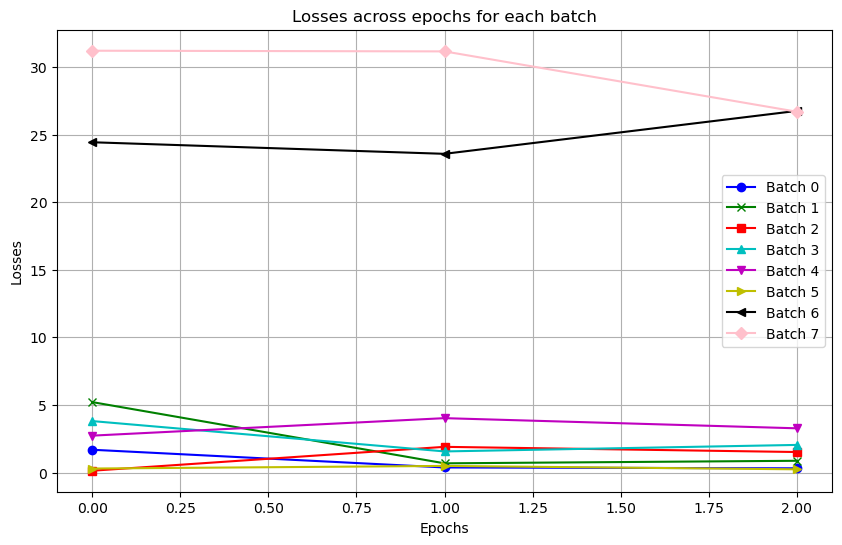

In [41]:
# Example data for multiple lines
epochs = [0, 1, 2]
batch_0_losses = np.array([1.6868, 0.3770, 0.3138])
batch_1_losses = np.array([5.2102, 0.6825, 0.8711])
batch_2_losses = np.array([0.1358, 1.9022, 1.5184])
batch_3_losses = np.array([3.8071, 1.5627, 2.0439])
batch_4_losses = np.array([2.7307, 4.0232, 3.2725])
batch_5_losses = np.array([0.2974, 0.4911, 0.2400])
batch_6_losses = np.array([24.4274, 23.5716, 26.7460])
batch_7_losses = np.array([31.1967, 31.1470, 26.6861])

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot multiple lines
plt.plot(epochs, batch_0_losses, marker='o', color='b', label='Batch 0')  
plt.plot(epochs, batch_1_losses, marker='x', color='g', label='Batch 1')  
plt.plot(epochs, batch_2_losses, marker='s', color='r', label='Batch 2') 
plt.plot(epochs, batch_3_losses, marker='^', color='c', label='Batch 3')  
plt.plot(epochs, batch_4_losses, marker='v', color='m', label='Batch 4')  
plt.plot(epochs, batch_5_losses, marker='>', color='y', label='Batch 5') 
plt.plot(epochs, batch_6_losses, marker='<', color='k', label='Batch 6')  
plt.plot(epochs, batch_7_losses, marker='D', color='pink', label='Batch 7')   

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Losses across epochs for each batch')
plt.legend()  # Add legend to distinguish lines
plt.grid(True)  # Add grid for better readability

# Show the plot
plt.show()


## Evaluate NN performance

### Trial 1

In [12]:
model = SGS_HF()  # Recreate the model instance
model.load_state_dict(torch.load('leap-persistent/panalluri/airSeaNN_temporal.pth'))
model.eval()  # Set the model to evaluation mode

SGS_HF(
  (hidden1): Linear(in_features=4, out_features=8, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=8, out_features=4, bias=True)
  (act2): ReLU()
  (output): Linear(in_features=4, out_features=1, bias=True)
)

In [13]:
#ground truth data that NN is trying to predict
y_true = torch.tensor(Qstar_stacked.isel(time=8).data.values, dtype=torch.float32)
y_true

tensor([-22.7881, -23.2886, -23.7266, -21.8767, -22.3571, -22.7773, -20.9902,
        -21.4496, -21.8518])

In [14]:
# input info for NN
x_urel = torch.tensor(u_rel_stacked.isel(time=8).values, dtype=torch.float32)
x_vrel = torch.tensor(v_rel_stacked.isel(time=8).values, dtype=torch.float32)
x_sst = torch.tensor(sst_stacked.isel(time=8).values, dtype=torch.float32)
x_tref = torch.tensor(t_ref_stacked.isel(time=8).values, dtype=torch.float32)
        
Xbatch = torch.stack((x_urel, x_vrel, x_sst, x_tref), dim=1)

In [15]:
with torch.no_grad(): #avoid extra computation in NN evaluation
    predictions = model(Xbatch)

In [16]:
# Convert predictions to numpy for metric calculation 
predictions = predictions.numpy()
y_true = y_true.numpy()

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate evaluation metrics
mse = mean_squared_error(y_true, predictions)
mae = mean_absolute_error(y_true, predictions)
r2 = r2_score(y_true, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 257.4769592285156
Mean Absolute Error: 16.02436637878418
R-squared: -367.8670349121094


### Plot comparison

In [18]:
import matplotlib.gridspec as gridspec

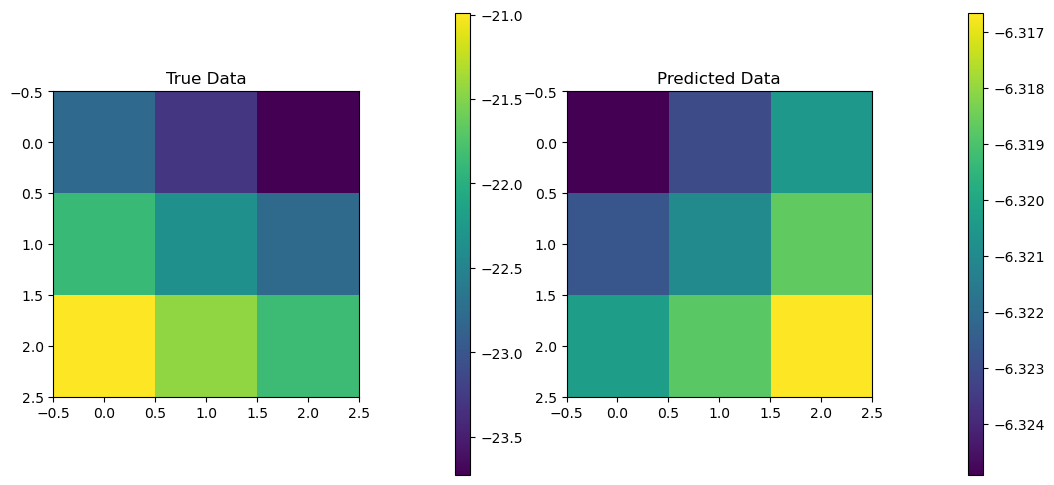

In [19]:
# Create a figure and a grid specification
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 0.05, 1, 0.05], wspace=0.6)

# Create subplots
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[2])
cax1 = plt.subplot(gs[1])
cax2 = plt.subplot(gs[3])

# Plot data on each subplot
cimg1 = ax1.imshow(y_true.reshape((3,3)), cmap='viridis')  # First subplot
ax1.set_title('True Data')

cimg2 = ax2.imshow(predictions.reshape((3,3)), cmap='viridis')  # Second subplot
ax2.set_title('Predicted Data')

# Add a colorbar
fig.colorbar(cimg1, cax=cax1)
fig.colorbar(cimg2, cax=cax2)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


### Trial 2

In [20]:
#ground truth data that NN is trying to predict
y_true = torch.tensor(Qstar_stacked.isel(time=9).data.values, dtype=torch.float32)

# input info for NN
x_urel = torch.tensor(u_rel_stacked.isel(time=9).values, dtype=torch.float32)
x_vrel = torch.tensor(v_rel_stacked.isel(time=9).values, dtype=torch.float32)
x_sst = torch.tensor(sst_stacked.isel(time=9).values, dtype=torch.float32)
x_tref = torch.tensor(t_ref_stacked.isel(time=9).values, dtype=torch.float32)
        
Xbatch = torch.stack((x_urel, x_vrel, x_sst, x_tref), dim=1)

with torch.no_grad(): #avoid extra computation in NN evaluation
    predictions = model(Xbatch)

# Convert predictions to numpy for metric calculation 
predictions = predictions.numpy()
y_true = y_true.numpy()

# Calculate evaluation metrics
mse = mean_squared_error(y_true, predictions)
mae = mean_absolute_error(y_true, predictions)
r2 = r2_score(y_true, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 19.150434494018555
Mean Absolute Error: 4.370053291320801
R-squared: -349.7537841796875


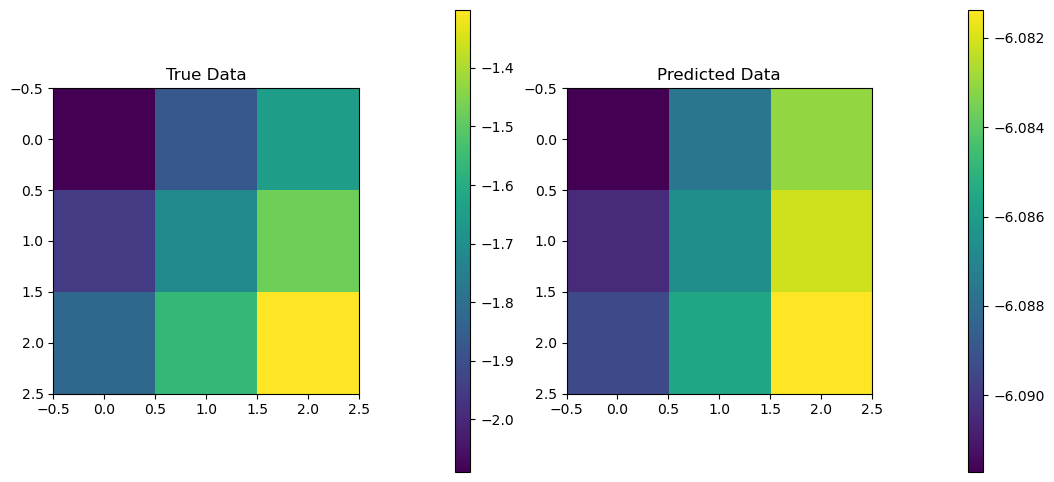

In [21]:
# Create a figure and a grid specification
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 0.05, 1, 0.05], wspace=0.6)

# Create subplots
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[2])
cax1 = plt.subplot(gs[1])
cax2 = plt.subplot(gs[3])

# Plot data on each subplot
cimg1 = ax1.imshow(y_true.reshape((3,3)), cmap='viridis')  # First subplot
ax1.set_title('True Data')

cimg2 = ax2.imshow(predictions.reshape((3,3)), cmap='viridis')  # Second subplot
ax2.set_title('Predicted Data')

# Add a colorbar
fig.colorbar(cimg1, cax=cax1)
fig.colorbar(cimg2, cax=cax2)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


### Trial 3

In [22]:
#ground truth data that NN is trying to predict
y_true = torch.tensor(Qstar_stacked.isel(time=10).data.values, dtype=torch.float32)

# input info for NN
x_urel = torch.tensor(u_rel_stacked.isel(time=10).values, dtype=torch.float32)
x_vrel = torch.tensor(v_rel_stacked.isel(time=10).values, dtype=torch.float32)
x_sst = torch.tensor(sst_stacked.isel(time=10).values, dtype=torch.float32)
x_tref = torch.tensor(t_ref_stacked.isel(time=10).values, dtype=torch.float32)
        
Xbatch = torch.stack((x_urel, x_vrel, x_sst, x_tref), dim=1)

with torch.no_grad(): #avoid extra computation in NN evaluation
    predictions = model(Xbatch)

# Convert predictions to numpy for metric calculation 
predictions = predictions.numpy()
y_true = y_true.numpy()

# Calculate evaluation metrics
mse = mean_squared_error(y_true, predictions)
mae = mean_absolute_error(y_true, predictions)
r2 = r2_score(y_true, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 97.55026245117188
Mean Absolute Error: 9.867952346801758
R-squared: -549.0772705078125


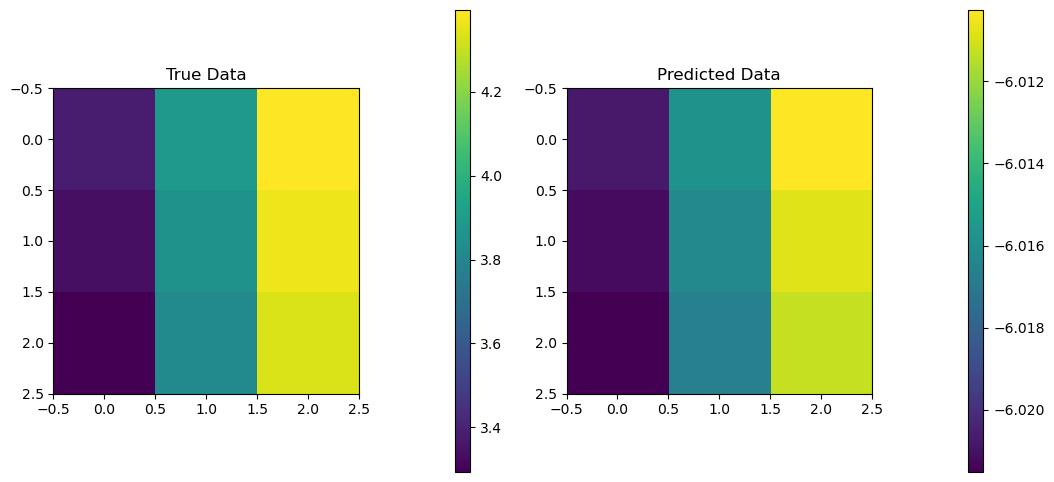

In [23]:
# Create a figure and a grid specification
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 0.05, 1, 0.05], wspace=0.6)

# Create subplots
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[2])
cax1 = plt.subplot(gs[1])
cax2 = plt.subplot(gs[3])

# Plot data on each subplot
cimg1 = ax1.imshow(y_true.reshape((3,3)), cmap='viridis')  # First subplot
ax1.set_title('True Data')

cimg2 = ax2.imshow(predictions.reshape((3,3)), cmap='viridis')  # Second subplot
ax2.set_title('Predicted Data')

# Add a colorbar
fig.colorbar(cimg1, cax=cax1)
fig.colorbar(cimg2, cax=cax2)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
